In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
import os

sys.path.append(os.path.join(os.getcwd(), '..', 'toolkits'))

from metrics import HV, violation, cum_violation, cum_regret, constraint_regret

# Evalution metrics

We here by provide the guidence for the user to use the code base to plot the evaluation metrics mentioned in the paper: 

*Simple Hypervolume(regret), Cumulative Hypervolume Regret, Simple Violation, Cumulative Violation, Constraint Regret*

The file of the python function is in `CMOBO/toolkits/metrics.py`

**Simple Hypervolme** `HV`

\begin{align*}
& \mathcal{HV}_z(Y_t) =\\
&~ \mathrm{vol}(\{y \in F(\mathfrak{F})|y \geq z, y \ \text{is dominiated by some} \ y' \in Y_t\}).
\end{align*}

And $z$ is a reference point. 

The function `HV` takes torch tensor `Y` and `z` as input, and return the Hypervolume value of `Y` with reference `z`.

 `Y` is the set of objservations $Y_t$ and `z` is the reference point $z$.

The value is computed and stored in the optimization process in the file `data_demo/hv_toy_#.pt`

**Cumulative Hypervolume Regret** `cum_regret`

Cumulative Hypervolume regret $\mathcal{R}_t$ is the cumulative sum of simple Hypervolume regret $r_t$
\begin{align*}
r_{t} &= \mathcal{HV}_z(\mathcal{P})-\mathcal{HV}_z(Y_t), \\
\mathcal{R}_{T} &= \sum_{t=1}^{T}r_{t}
\end{align*}

where $\mathcal{P}$  is  the Pareto front. 

`cum_regret` takes an array of Hypervolume value and the value of $\mathcal{HV}_z(\mathcal{P})$ as input and return the cumulative hypervolume regret.

**Simple violation, Cumulative violation** `violation, cum_violation`
  
`violation, cum_violation`  calculate constraint violation when the constraints are of the specific form:

\begin{align*}
f_i(\mathbb{x}) \geq s_i, \forall \in \{1,..,m\}
\end{align*}

where $s_i$ are constant threshold values for the objectives.

Similar to the hypervolume and cumulative hypervolume regret, The `violation` functions takes an array of queried objective values and returns an array that contains the sum of violation of each objective, $\sum_i v_{i,t}$ at each iteration $t$.

**Constraint Regret** `constraint_regret`

`constraint_regret` computes the value of the constraint regret. It takes prepared arrays of hypervolume values and violation values and an maximum hypervoume value as input an returns an array of constraint regret defined as:

\begin{align*}
\mathcal{C_t} = \min_{\tau \in [t]} \{ r_{\tau} + \sum_{j = 1}^{c}v_{j,\tau} \}
\end{align*}

The function will re-scale the terms $r_{\tau}$ and $\sum_{j = 1}^{c}v_{j,\tau}$ to the common range $[0,1]$.

# Demonstration

1. Simple hypervolume

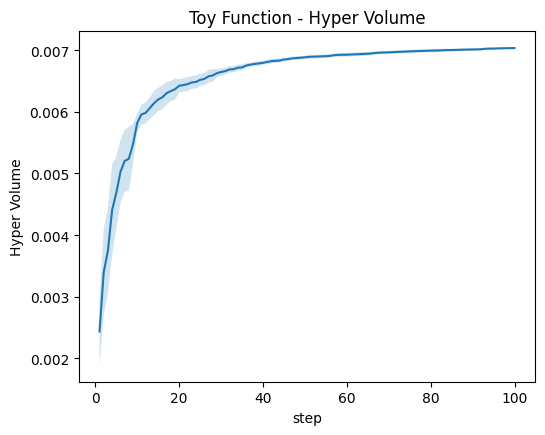

In [13]:
#Empty tensor for data storing
hv_toy = torch.zeros(10, 100)

#the threshold values for the threshold constraints
thresholds = torch.tensor([-1.9, -2.25], dtype= torch.float64)

#load the hypervolume values
for i in range(10):
    hv_toy[i,:] = torch.load(os.path.join(os.getcwd(), 'data_demo', f'hv_toy_{i+1}.pt'))


##plotting the results
hv = [hv_toy]
mean = []
std = []
for data in hv:
    mean.append(data.mean(dim = 0))
    std.append(data.std(dim = 0))
plt.figure(figsize=(5.89, 4.55))
for i in range(1):
    plt.plot(range(1,101), mean[i])
for i in range(1):
    plt.fill_between(range(1,101), mean[i] + 0.619 * std[i], mean[i] - 0.619 * std[i], alpha = 0.2)
plt.title('Toy Function - Hyper Volume')
plt.xlabel('step')
plt.ylabel('Hyper Volume')
plt.show()

2. Cumulative HV regret

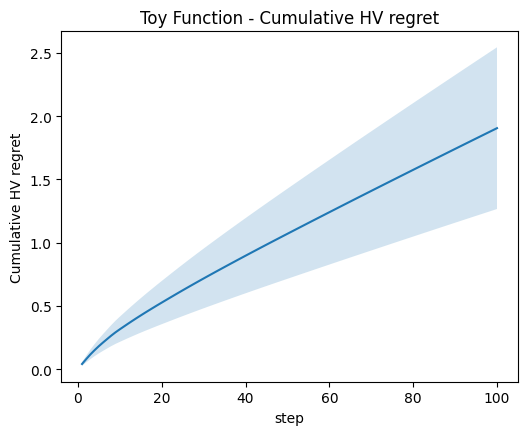

In [14]:
mean_rg = []
plt.figure(figsize=(5.89, 4.55))
std_rg = []
for data in hv:
    #data is the tensor of hypervolume values
    #0.01 is the maximum hyervolume value for the regret computation
    cum_rg = cum_regret(data, 0.01)
    mean_rg.append(cum_rg.mean(dim = 0))
    std_rg.append(cum_rg.std(dim = 0))
for i in range(1):
    plt.plot(range(1,101), mean_rg[i])
for i in range(1):
    plt.fill_between(range(1,101), mean_rg[i] + 0.619 * std_rg[i], mean_rg[i] - 0.619 * std_rg[i], alpha = 0.2)
plt.title('Toy Function - Cumulative HV regret')
plt.xlabel('step')
plt.ylabel('Cumulative HV regret')
plt.show()

3. Cumulative Violation

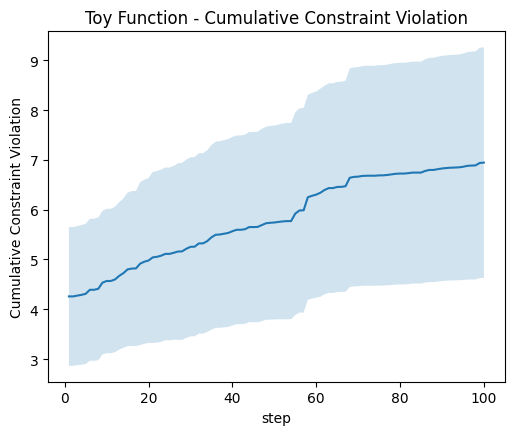

In [15]:
vio_toy = torch.zeros(10, 100)

#load the violation value, in this case, compute the violation value with the queried objective value in each iteration and the threshold value.
for i in range(10):
    vio_toy[i,:] = violation(torch.load(os.path.join(os.getcwd(), 'data_demo', f'obj_toy_{i+1}.pt'))[-101:-1,:], thresholds)

vio = [vio_toy]

mean_vio = []
std_vio = []
plt.figure(figsize=(5.89, 4.55))
for data in vio:
    cum_vio = cum_violation(data)
    mean_vio.append(cum_vio.mean(dim = 0))
    std_vio.append(cum_vio.std(dim = 0))
for i in range(1):
    plt.plot(range(1,101), mean_vio[i])
for i in range(1):
    plt.fill_between(range(1,101), mean_vio[i] + 0.619 * std_vio[i], mean_vio[i] - 0.619 * std_vio[i], alpha = 0.2)
plt.title('Toy Function - Cumulative Constraint Violation')
#plt.legend(['CMOBO', 'Random', 'qParEGO', 'qNEHVI', 'MESMOC'])
plt.xlabel('step')
plt.ylabel('Cumulative Constraint Violation')
plt.show()

4. constraint regret

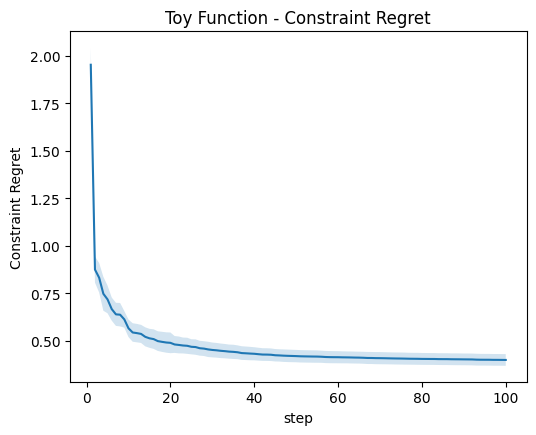

In [16]:
crg = torch.zeros(10, 100)

crg = [crg]
for i in range(1):
    #prepare the hypervolume and violation values
    algo_hv = hv[i]
    algo_vio = vio[i]
    for ii in range(10):
        # compute the constraint regret by the constraint violation, the simple hypervolume, and the maximum hypervolume
        crg[i][ii,:] = constraint_regret(algo_vio[ii,:], algo_hv[ii, :], 0.01)

plt.figure(figsize=(5.89, 4.55))
mean_crg = []
std_crg = []
for data in crg:
    mean_crg.append(data.mean(dim = 0))
    std_crg.append(data.std(dim = 0))
for i in range(1):
    plt.plot(range(1,101), mean_crg[i])
for i in range(1):
    plt.fill_between(range(1,101), mean_crg[i] + 0.619 * std_crg[i], mean_crg[i] - 0.619 * std_crg[i], alpha = 0.2)
plt.title('Toy Function - Constraint Regret')
#plt.legend(['CMOBO', 'Random', 'qParEGO', 'qNEHVI', 'MESMOC'])
plt.xlabel('step')
plt.ylabel('Constraint Regret')
plt.show()